<a href="https://colab.research.google.com/github/y-jacobs/RL_Project/blob/main/Sokoban.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Reinforcements Learning
Hello dear students,<br> this is the template notebook. Please click on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1: Or Gottman
<br>
Student 2: Yahel Jacobs
<br><br>
<img src="https://play-lh.googleusercontent.com/e_oKlKPISbgdzut1H9opevS7-LTB8-8lsmpCdMkhlnqFenZhpjxbLmx7l158-xQQCIY">

### https://github.com/mpSchrader/gym-sokoban

# Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym_sokoban
!git clone https://github.com/avivg7/sokoban-so.git
!unzip /content/sokoban-so/Compress.zip

# Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
from soko_pap import *
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time

# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

Function - given an environment it will print us the details about observation, actions, agent's position and boxes locations

In [ ]:
def print_env_det(env):
  print(f'Observation space: {env.observation_space}'
      f'\nAction space: {env.action_space}'
      f'\nPlayer position:{env.player_position}'
      f'\nBox location: {find_box_location(env)}')

Function - given an environment it will return the indexes position and boxes locations

In [ ]:
def find_box_location(env):
    idx = np.argmax(env.room_state == 4)
    if env.room_state.flat[idx] == 4:
        return np.unravel_index(idx, env.room_state.shape)
    return None

In [ ]:
def find_agent_location(env):
    idx = np.argmax(env.room_state == 5)
    if env.room_state.flat[idx] == 5:
        return np.unravel_index(idx, env.room_state.shape)
    return None

# Download Models

In [ ]:
!gdown 13XOA4ALp2SiCW8GjNW6rl18g4R0r0Q9n # actor
!gdown 13XrLMZX1Xg5FmZjb8WEo5YIA0TCJETCw # critic
!gdown 1-4ZydsrvK7vX9oAhbdpzhp4bAPs5Aa3z # DQN


Downloading...
From: https://drive.google.com/uc?id=13XOA4ALp2SiCW8GjNW6rl18g4R0r0Q9n
To: /content/SOKOBAN_actor_weight.h5
100% 16.1M/16.1M [00:00<00:00, 191MB/s]
Downloading...
From: https://drive.google.com/uc?id=13XrLMZX1Xg5FmZjb8WEo5YIA0TCJETCw
To: /content/SOKOBAN_critic_weight.h5
100% 1.31M/1.31M [00:00<00:00, 126MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-4ZydsrvK7vX9oAhbdpzhp4bAPs5Aa3z
To: /content/SOKOBAN_DQN_weight.h5
100% 16.1M/16.1M [00:00<00:00, 101MB/s] 


# Feeling the Env

## EX1 - FIX SCENARIO -  PUSH & PULL - ONE BOX

###EX1 - Train Actor-Critic

In [ ]:
#=============== DO NOT DELETE ===============
random.seed(2)
sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
# ============================================

Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[1 1]
Box location: (2, 2)


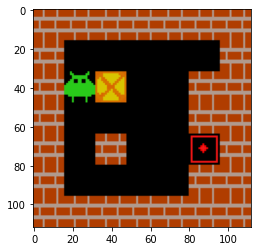

In [ ]:
screen = sok.render(mode='rgb_array')
plt.imshow(sok.render('rgb_array'))
observation, reward, done, _ = sok.step(1)
print_env_det(sok)

In [ ]:
import gym
import random
import os
import numpy as np
from tensorflow import keras
from collections      import deque
from keras.models     import Sequential
from keras.layers     import Dense, Conv2D, Flatten
from keras.optimizers import Adam
from keras.engine.training import is_functional_model_init_params
from sklearn.metrics import mean_squared_error
from skimage import io, color

In [ ]:
class ActorCriticAgent():
    def __init__(self, state_size, action_size, build=True):
        self.weight_actor_backup = "/content/SOKOBAN_actor_weight.h5"
        self.weight_critic_backup = "/content/SOKOBAN_critic_weight.h5"
        self.rewards_file = "/content/drive/MyDrive/rl_project/rewards_a2c.txt"
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.learning_rate_actor = 0.001
        self.learning_rate_critic = 0.005
        self.gamma = 0.99
        self.exploration_rate = 1.0
        self.exploration_min = 0.01
        self.exploration_decay = 0.995
        if build:
            self.actor = self._build_actor_model()
            self.critic = self._build_critic_model()
        else:
            self.actor = keras.models.load_model(self.weight_actor_backup)
            self.critic = keras.models.load_model(self.weight_critic_backup)

    def _build_actor_model(self):
        # Neural Net for Actor Model
        model = Sequential()
        model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=self.state_size, padding='same'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Flatten())
        model.add(Dense(self.action_size, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.learning_rate_actor))
        return model

    def _build_critic_model(self):
        # Neural Net for Critic Model
        model = Sequential()
        model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=self.state_size, padding='same'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Flatten())
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate_critic))
        return model

    def save_model(self, reward=0):
        self.actor.save(self.weight_actor_backup)
        self.critic.save(self.weight_critic_backup)
        # file = open(self.rewards_file, "a")
        # file.write(str(reward) + ',')
        # file.close()

    def act(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        action_prob = self.actor.predict(state)[0][0][0]
        # print(action_prob, action_prob.shape)
        return np.random.choice(self.action_size, p=action_prob)

    def remember(self, state, action, reward, next_state, done, info):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, sample_batch_size):
        if len(self.memory) < sample_batch_size:
            return

        sample_batch = random.sample(self.memory, sample_batch_size)

        for state, action, reward, next_state, done in sample_batch:
            target = reward

            if not done:
                # Update Critic
                value_next = self.critic.predict(next_state)
                value = self.critic.predict(state)
                target = reward + self.gamma * value_next
                advantage = target - value

                # Update Actor
                action_probs = self.actor.predict(state)[0]
                action_one_hot = np.zeros(self.action_size)
                action_one_hot[action] = 1
                log_prob = np.log(action_probs[action])
                loss_actor = -log_prob * advantage
                loss_critic = np.mean(np.square(target - value)) # mean_squared_error(target, value)
                loss = loss_actor + loss_critic

                # Backpropagate loss through actor and critic networks
                self.actor.train_on_batch(state, advantage * action_one_hot)
                self.critic.train_on_batch(state, np.array([target]))

                # Decay exploration rate
                if self.exploration_rate > self.exploration_min:
                    self.exploration_rate *= self.exploration_decay



In [ ]:
reward_dict = {
    'visited': -0.7,
    'invalid': -0.8,
    'val_move': -0.04,
    'val_move_box': +0.6,
    'goal': +1.0
}

In [ ]:
class Sokoban:
    def __init__(self):
        self.sample_batch_size = 64
        self.episodes          = 3 # 1000
        self.env               = sok
        self.state_size        =  (80, 80, 1)
        self.action_size       = self.env.action_space.n
        self.agent             = ActorCriticAgent(self.state_size, self.action_size, False)


    def run(self):
        try:
            for index_episode in range(self.episodes):
                random.seed(2)
                sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
                env = sok
                state, reward, done, _ = sok.step(1)
                state = color.rgb2gray(state[16:96, 16:96]).reshape(1, 80, 80, 1)

                done = False
                index = 0
                total_reward = list()
                while not done:
                    visited = np.zeros((7, 7))
                    action = self.agent.act(state)
                    next_state, reward, done, info = env.step(action)
                    if info['action.name'] == "no operation" or info["action.moved_player"] == False:
                        reward += reward_dict['invalid']
                    if info["action.moved_box"]:
                        reward += reward_dict['val_move_box']
                    if info["action.moved_player"]:
                        if visited[find_agent_location(env)] == 1:
                            reward += reward_dict['visited']
                        else:
                            reward += reward_dict['val_move']
                    else:
                        reward += -0.4
                    if "all_boxes_on_target" in info.keys():
                        if info["all_boxes_on_target"]:
                            reward += reward_dict['goal']

                    total_reward.append(reward)
                    next_state = color.rgb2gray(next_state[16:96, 16:96]).reshape(1, 80, 80, 1)
                    self.agent.remember(state, action, reward, next_state, done, info)
                    state = next_state
                    visited[find_agent_location(env)]=1
                    index += 1
                print("Episode {}# steps: {}, total reward: {}, last reward: {}, rewards_list: {}".format(index_episode, index + 1, sum(total_reward), reward, total_reward))
                self.agent.save_model(sum(total_reward))
                self.agent.replay(self.sample_batch_size)
        finally:
            self.agent.save_model()


In [ ]:
# sokoban = Sokoban()
# sokoban.run()

### EX1 - Video test

In [ ]:
random.seed(2)
sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
env = sok
state, reward, done, _ = sok.step(1)

agent = ActorCriticAgent((80, 80, 1), env.action_space.n, False)

state = color.rgb2gray(state[16:96, 16:96]).reshape(1, 80, 80, 1)
start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  while (iter < 10) or not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    next_state = color.rgb2gray(next_state[16:96, 16:96]).reshape(1, 80, 80, 1)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

## EX2 - PUSH & PULL - ONE BOX

###EX2 - Train DQN

In [ ]:
#=============== DO NOT DELETE ===============
sok_2 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
# ============================================

Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[4 1]
Box location: (4, 2)


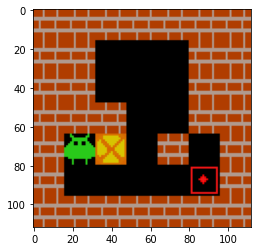

In [ ]:
screen = sok_2.render(mode='rgb_array')
plt.imshow(sok_2.render('rgb_array'))
observation, reward, done, _ = sok_2.step(1)
print_env_det(sok_2)

In [ ]:
import gym
import random
import os
import numpy as np
from tensorflow import keras
from collections      import deque
from keras.models     import Sequential
from keras.layers     import Dense, Conv2D, Flatten
from keras.optimizers import Adam
from keras.engine.training import is_functional_model_init_params
from skimage import io, color

In [ ]:
from keras.engine.training import is_functional_model_init_params
class DQNAgent():
    def __init__(self, state_size, action_size, build=True):
        self.weight_backup      = "/content/SOKOBAN_DQN_weight.h5"
        self.rewards_file       = "/content/drive/MyDrive/rl_project/rewards_DQN.txt"
        self.state_size         = state_size
        self.action_size        = action_size
        self.memory             = deque(maxlen=2000)
        self.learning_rate      = 0.001
        self.gamma              = 0.95
        self.exploration_rate   = 1.0
        self.exploration_min    = 0.01
        self.exploration_decay  = 0.995
        if build:
            self.brain              = self._build_model()
        else:
            self.brain              = keras.models.load_model(self.weight_backup)

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=self.state_size, padding='same'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Flatten())
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        '''if os.path.isfile(self.weight_backup):
            model.load_weights(self.weight_backup)
            self.exploration_rate = self.exploration_min'''
        return model

    def save_model(self, reward=0):
            self.brain.save(self.weight_backup)
            # open file for writing
            # file = open(self.rewards_file, "a")
            # file.write(str(reward) + ',')
            # file.close()

    def load_model(self):
            self.brain.save(self.weight_backup)

    def act(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        act_values = self.brain.predict(state)
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done, info):
        self.memory.append((state, action, reward, next_state, done, info))

    def replay(self, sample_batch_size):
        if len(self.memory) < sample_batch_size:
            return
        sample_batch = random.sample(self.memory, sample_batch_size)
        for state, action, reward, next_state, done, info in sample_batch:
            target = reward

            if not done:
              target = reward + self.gamma * np.amax(self.brain.predict(next_state)[0])
            target_f = self.brain.predict(state)
            target_f[0][action] = target
            self.brain.fit(next_state, target_f, epochs=1, verbose=0)
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

In [ ]:
reward_dict = {
    'visited': -0.7,
    'invalid': -0.8,
    'val_move': -0.04,
    'val_move_box': +0.6,
    'goal': +1.0
}

In [ ]:
class Sokoban:
    def __init__(self):
        self.sample_batch_size = 64
        self.episodes          = 200
        self.env               = sok_2

        self.state_size        =  (80, 80, 1)
        self.action_size       = self.env.action_space.n
        self.agent             = DQNAgent(self.state_size, self.action_size, False)


    def run(self):
        try:
            for index_episode in range(self.episodes):
                state = self.env.reset()
                state = color.rgb2gray(state[16:96, 16:96]).reshape(1, 80, 80, 1)

                done = False
                index = 0
                total_reward = list()
                while not done:
                    visited = np.zeros((7, 7))
                    action = self.agent.act(state)
                    next_state, reward, done, info = self.env.step(action)
                    if info['action.name'] == "no operation" or info["action.moved_player"] == False:
                        reward += reward_dict['invalid']
                    if info["action.moved_box"]:
                        reward += reward_dict['val_move_box']
                    if info["action.moved_player"]:
                        if visited[find_agent_location(env)] == 1:
                            reward += reward_dict['visited']
                        else:
                            reward += reward_dict['val_move']
                    else:
                        reward += -0.4
                    if "all_boxes_on_target" in info.keys():
                        if info["all_boxes_on_target"]:
                            reward += reward_dict['goal']

                    total_reward.append(reward)
                    next_state = color.rgb2gray(next_state[16:96, 16:96]).reshape(1, 80, 80, 1)
                    self.agent.remember(state, action, reward, next_state, done, info)
                    state = next_state
                    visited[find_agent_location(env)]=1
                    index += 1
                print("Episode {}# steps: {}, total reward: {}, last reward: {}, rewards_list: {}".format(index_episode, index + 1, sum(total_reward), reward, total_reward))
                self.agent.save_model(sum(total_reward))
                self.agent.replay(self.sample_batch_size)
        finally:
            self.agent.save_model()


In [ ]:
# sokoban = Sokoban()
# sokoban.run()

### EX2 - Video test

In [ ]:
env = sok_2
agent = DQNAgent((80, 80, 1), env.action_space.n, False)

In [ ]:
state = env.reset()
state = color.rgb2gray(state[16:96, 16:96]).reshape(1, 80, 80, 1)
start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  while (iter < 10) or not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    next_state = color.rgb2gray(next_state[16:96, 16:96]).reshape(1, 80, 80, 1)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

###Test

In [ ]:
# import matplotlib.pyplot as plt

# env = sok_2
# agent = DQNAgent((80, 80, 1), env.action_space.n, False)

# rewards = []
# for i in range(100):
#   state = env.reset()
#   state = color.rgb2gray(state[16:96, 16:96]).reshape(1, 80, 80, 1)
#   done = False
#   reward_sum = 0
#   while  not done:
#     action = agent.act(state) # env.action_space.sample()
#     next_state, reward, done, info = env.step(action)
#     next_state = color.rgb2gray(next_state[16:96, 16:96]).reshape(1, 80, 80, 1)
#     reward_sum += reward
#   rewards.append(reward_sum)


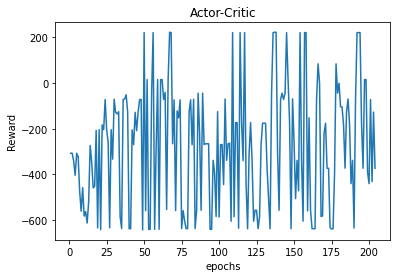

In [ ]:
# epochs = list(range(1, len(rewards) + 1))  # list of epochs from 1 to 100
# # average_reward = sum(rewards) / len(rewards)  # calculate the average reward
# plt.plot(epochs, rewards)  # create a line plot
# # plt.axhline(y=average_reward, color='r', linestyle='--')  # add a red dashed line at the average reward
# plt.xlabel('epochs')  # set x-axis label
# plt.ylabel('Reward')  # set y-axis label
# plt.title('Actor-Critic')  # set title of the graph
# plt.show()  # show the graph